In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import pandas as pd
import cmcrameri as cmcm
import juanfit

In [2]:
df = pd.read_excel("../../save/eis_line_list_final.xlsx",sheet_name="resolve")
df

,ion,charge_stat,Z,A,temp,wvl_fit,wvl_chianti,fwhm_fit,fwhm_err,fwhm_true,fwhm_awsom,quality,desc
0,Fe,x,9,55.85000,5.9,174.417,174.531,0.079,0.002,0.0380,0.0430,a,NaN
1,Fe,ix,8,55.85000,5.8,176.866,176.945,0.065,0.008,NaN,0.0405,c,NaN
2,Fe,x,9,55.85000,5.9,177.125,177.240,0.081,0.001,0.0407,0.0436,a,NaN
3,Fe,xi,10,55.85000,6.0,182.058,182.167,0.079,0.002,0.0381,0.0507,a,NaN
4,Fe,x,9,55.85000,5.9,182.199,182.307,0.087,0.006,0.0517,0.0411,b,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Mg,vii,6,24.30500,5.8,280.617,280.742,0.078,0.010,0.0362,0.0663,b,NaN
81,Al,ix,8,26.98154,5.9,282.305,282.422,0.093,0.020,0.0629,0.0749,b,NaN
82,Al,ix,8,26.98154,5.9,283.922,284.042,0.091,0.008,0.0594,0.0877,b,NaN
83,Fe,xv,14,55.85000,6.2,284.051,284.163,0.056,0.009,NaN,0.0600,c,sim too hot


In [3]:
def aver_err(data,err,thresh=1.e-5,iter_max=1000):
    sigma_sq = np.var(data)
    n_data = len(data)

    if type(data) is list:
        data = np.array(data)
    if type(err) is list:
        err = np.array(err)

    err_sq_mean = np.mean(np.square(err)) 
    for ii in range(iter_max):
        weight = 1./(sigma_sq + err**2)
        weight = weight/np.sum(weight)
        aver_new = np.sum(weight*data)
        sigma_new_sq = np.max([0.,n_data/(n_data - 1.)*np.sum(weight*np.square(data-aver_new)) - \
                                err_sq_mean])
        
        #print(aver_new,sigma_new_sq)
        if np.abs(sigma_new_sq/sigma_sq - 1) < thresh:
            break
        else:
            sigma_sq = sigma_new_sq

    sigma_tot = np.sqrt(1./np.sum(1./(sigma_new_sq + err**2)))
    return aver_new, sigma_tot

aver_err([10,12,7,8],[0.8,1.2,0.5,1.5])

(9.1673963016428, 1.0989182072775892)

In [4]:
def plot_eis_awsom_width(df,ion,charge=None,quality="a",plot_mle=False,print_df=False):
    c = const.c.cgs/1.e5

    if type(ion) is str:
        ion = [ion]
    if type(charge) is str:
        charge = [charge]
    if type(quality) is str:
        quality = [quality]
    
    if charge is None:
        df_plot = df[(df["ion"].isin(ion)) & (df["quality"].isin(quality))]
    else:
        df_plot = df[(df["ion"].isin(ion)) & (df["charge_stat"].isin(charge)) \
                    & (df["quality"].isin(quality))]

    line_name = df_plot["ion"] + r" \textsc{"+ df_plot["charge_stat"] + r"} " + \
         ((df_plot["wvl_chianti"].values).astype("int")).astype("str")

    eis_veff = df_plot["fwhm_true"]/df_plot["wvl_chianti"]*c

    awsom_veff = df_plot["fwhm_awsom"]/df_plot["wvl_chianti"]*c

    eis_veff_err = df_plot["fwhm_err"]*df_plot["fwhm_fit"] \
                    /df_plot["fwhm_true"]/df_plot["wvl_chianti"]*c


    n_lines = len(df_plot.index)
    plot_x = np.arange(n_lines)

    fig, ax = plt.subplots(figsize=(n_lines+2,6),constrained_layout=True)

    if plot_mle is True:
        best_est,err_est = aver_err(eis_veff,eis_veff_err)
        ax.axhspan(best_est-err_est,best_est+err_est,color="#FAD689",alpha=0.9)
        ax.axhspan(best_est-3*err_est,best_est+3*err_est,color="#FAD689",alpha=0.5)
        ax.axhline(best_est,color="#FFB11B",lw=2,ls="--",label=r"$\bar{v}_{\rm eff}$")
    ax.errorbar(plot_x,eis_veff,eis_veff_err,color="#CC543A",ls="none",marker="o",
                markersize=6,capsize=5,lw=2,label="EIS",zorder=15)

    ax.scatter(plot_x,awsom_veff,color="#0089A7",marker="o",
                lw=3,label="AWSoM",zorder=14)



    ax.set_xticks(plot_x)
    ax.set_xticklabels(line_name)
    ax.tick_params(labelsize=16)
    ax.set_xlabel("Line",fontsize=16)
    ax.set_ylabel(r"Effective Velocity $v_{\rm eff}\ \left[\mathrm{km \cdot s^{-1}} \right]$",
                    fontsize=16)

    if charge is not None:
        title = r"\textbf{" + ion[0] + ' '.join([r" \textsc{" + charge_ +r"} " for charge_ in charge]) + \
                r"}"
    else:
        title = r"\textbf{" + ion[0] + r"}"
    ax.set_title(title,fontsize=18)
    ax.tick_params(which="major",width=1.2,length=8,direction="in")
    ax.tick_params(which="minor",width=1.2,length=4,direction="in")
    ax.grid("on")
    ax.legend(loc = 'lower left',fontsize = 18,frameon=False)

    if print_df:
        print(df_plot)

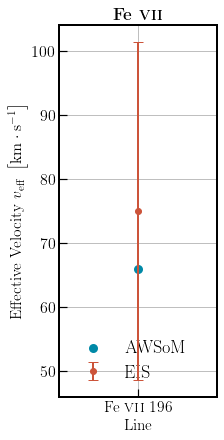

In [5]:
plot_eis_awsom_width(df,"Fe","vii",quality=["a","b"])

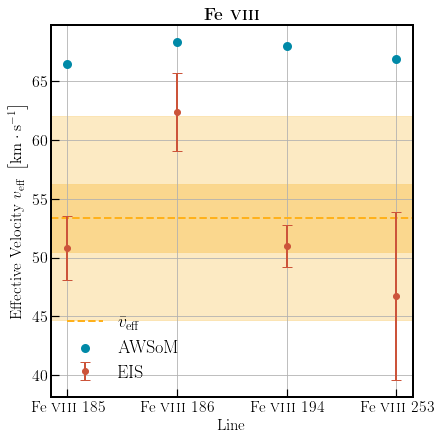

In [6]:
plot_eis_awsom_width(df,"Fe","viii",quality=["a"],plot_mle=True)

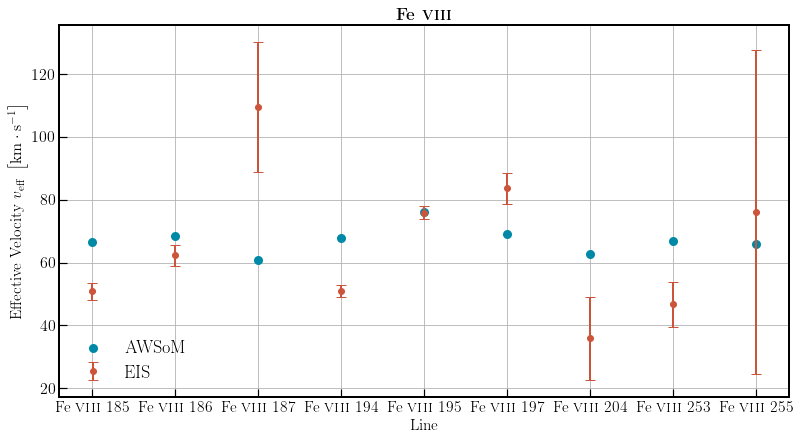

In [7]:
plot_eis_awsom_width(df,"Fe","viii",quality=["a","b"])

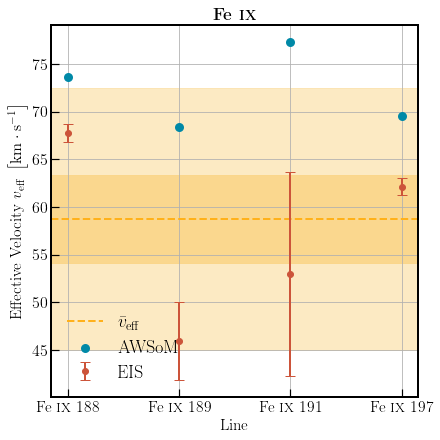

In [8]:
plot_eis_awsom_width(df,"Fe","ix",quality=["a"],plot_mle=True)

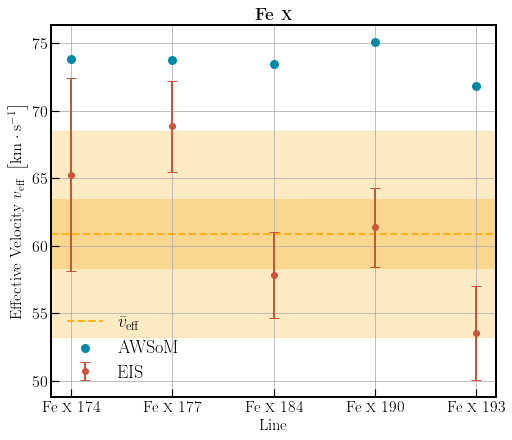

In [9]:
plot_eis_awsom_width(df,"Fe","x",quality=["a"],plot_mle=True)

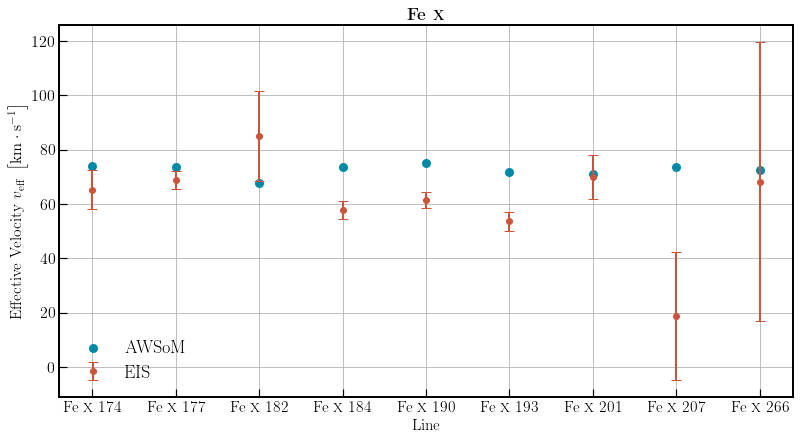

In [10]:
plot_eis_awsom_width(df,"Fe","x",quality=["a","b"],plot_mle=False)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


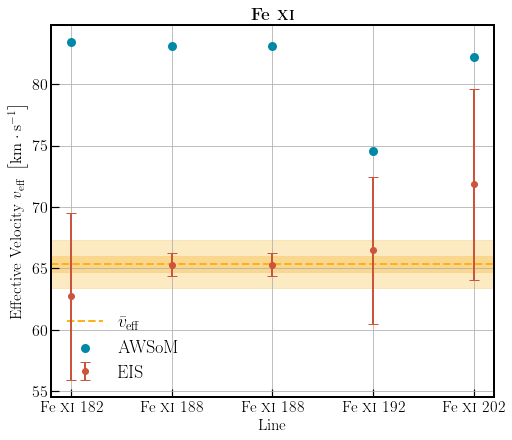

In [11]:
plot_eis_awsom_width(df,"Fe","xi",quality=["a"],plot_mle=True)

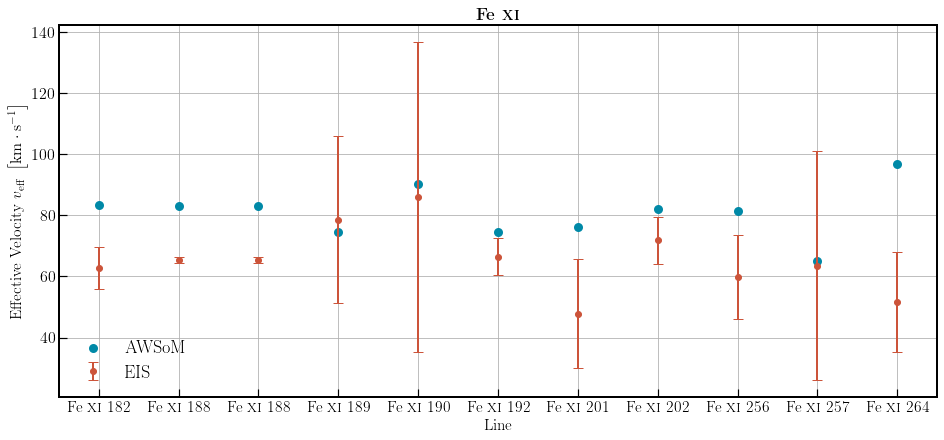

In [12]:
plot_eis_awsom_width(df,"Fe","xi",quality=["a","b"],plot_mle=False)

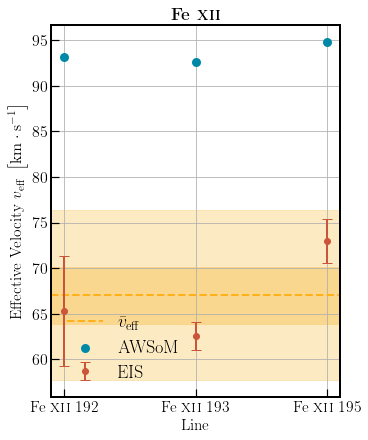

In [13]:
plot_eis_awsom_width(df,"Fe","xii",quality=["a"],plot_mle=True)

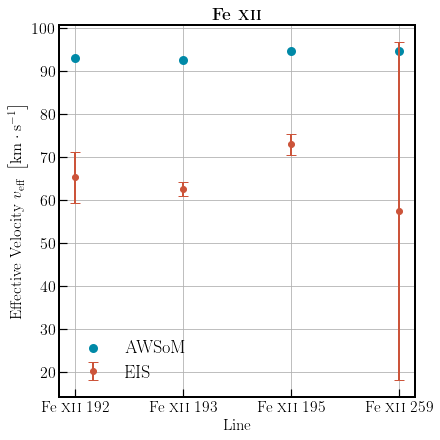

In [14]:
plot_eis_awsom_width(df,"Fe","xii",quality=["a","b"])

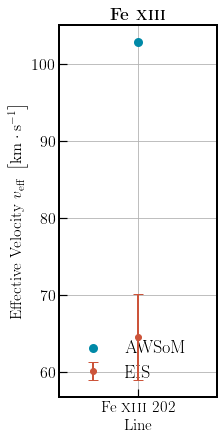

In [15]:
plot_eis_awsom_width(df,"Fe",["xiii"],quality=["a"])

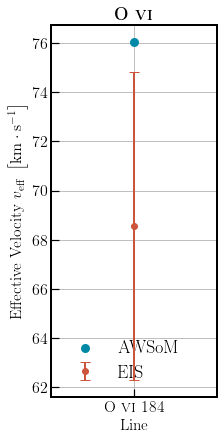

In [16]:
plot_eis_awsom_width(df,"O",["vi"],quality=["a"])

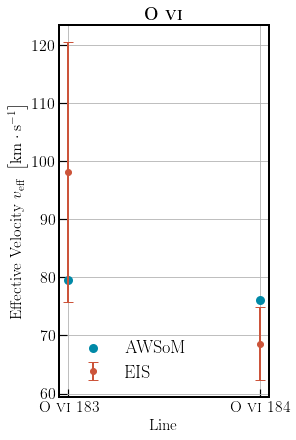

In [17]:
plot_eis_awsom_width(df,"O",["vi"],quality=["a","b"])

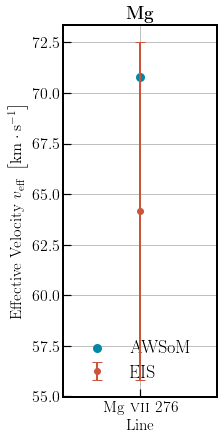

In [18]:
plot_eis_awsom_width(df,"Mg",quality=["a"])

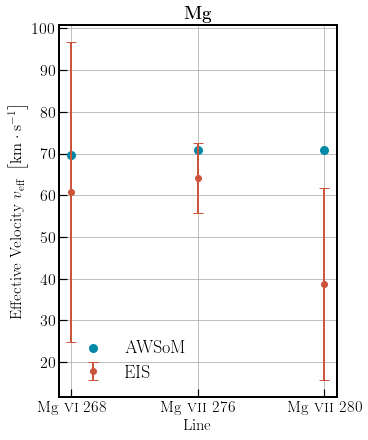

In [19]:
plot_eis_awsom_width(df,"Mg",quality=["a","b"])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


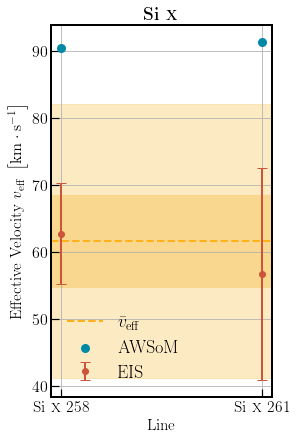

In [20]:
plot_eis_awsom_width(df,"Si","x",quality=["a"],plot_mle=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


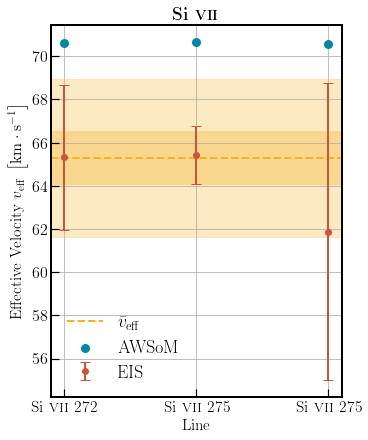

In [21]:
plot_eis_awsom_width(df,"Si","vii",quality=["a"],plot_mle=True)